In [ ]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
from torch.nn.utils.rnn import pad_sequence
import pandas as pd
import numpy as np
from transformers import BertTokenizer
from transformers import BertForSequenceClassification
from datasets import Dataset
from nltk.stem.snowball import SnowballStemmer
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import tensorflow as tf
from transformers import DistilBertTokenizer, TFDistilBertForSequenceClassification
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional , RNN , GRU , SimpleRNN
from tensorflow.keras.optimizers import Adam
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('stopwords')

2025-08-27 21:38:44.685472: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1756330725.054116      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1756330725.155381      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
def clean(df):
    stop_words = set(stopwords.words('english'))
    lemmatizer = WordNetLemmatizer()

    RE_WSPACE = re.compile(r"\s+")
    RE_TAGS = re.compile(r"<[^>]+>")
    RE_ASCII = re.compile(r"[^A-Za-z0-9À-ž ]")   
    RE_SINGLECHAR = re.compile(r"\b[A-Za-zÀ-ž]\b")

    for i in range(len(df)):
        sentence = df.loc[i, 'all_text']

        sentence = re.sub(RE_TAGS, " ", sentence)
        sentence = re.sub(RE_ASCII, " ", sentence)
        sentence = re.sub(RE_SINGLECHAR, " ", sentence)
        sentence = re.sub(RE_WSPACE, " ", sentence)

        sentence = word_tokenize(sentence)
        sentence = [word.lower() for word in sentence]
        sentence = [word for word in sentence if word not in stop_words]
        #sentence = [lemmatizer.lemmatize(word) for word in sentence]

        df.loc[i, 'all_text'] = " ".join(sentence)

    return df


In [4]:
import kagglehub
from kagglehub import KaggleDatasetAdapter

# Load Fake.csv
fake = kagglehub.load_dataset(
    KaggleDatasetAdapter.PANDAS,
    "clmentbisaillon/fake-and-real-news-dataset",
    "Fake.csv"
)

# Load True.csv
true = kagglehub.load_dataset(
    KaggleDatasetAdapter.PANDAS,
    "clmentbisaillon/fake-and-real-news-dataset",
    "True.csv"
)

print("Fake news sample:")
print(fake.head())

print("\nTrue news sample:")
print(true.head())

/tmp/ipykernel_36/2498793515.py:5: DeprecationWarning: load_dataset is deprecated and will be removed in a future version.
  fake = kagglehub.load_dataset(
/tmp/ipykernel_36/2498793515.py:12: DeprecationWarning: load_dataset is deprecated and will be removed in a future version.
  true = kagglehub.load_dataset(


Fake news sample:
                                               title  \
0   Donald Trump Sends Out Embarrassing New Year’...   
1   Drunk Bragging Trump Staffer Started Russian ...   
2   Sheriff David Clarke Becomes An Internet Joke...   
3   Trump Is So Obsessed He Even Has Obama’s Name...   
4   Pope Francis Just Called Out Donald Trump Dur...   

                                                text subject  \
0  Donald Trump just couldn t wish all Americans ...    News   
1  House Intelligence Committee Chairman Devin Nu...    News   
2  On Friday, it was revealed that former Milwauk...    News   
3  On Christmas day, Donald Trump announced that ...    News   
4  Pope Francis used his annual Christmas Day mes...    News   

                date  
0  December 31, 2017  
1  December 31, 2017  
2  December 30, 2017  
3  December 29, 2017  
4  December 25, 2017  

True news sample:
                                               title  \
0  As U.S. budget fight looms, Republicans flip

In [5]:
fake['label'] = 0
true['label'] = 1

In [6]:
df = pd.concat([true, fake], ignore_index=True)
df['all_text'] = df['title'] + " " + df['text']
df = df.drop(columns = ['title' , 'text' , 'date' , 'subject'])

df.head()

,label,all_text
0,1,"As U.S. budget fight looms, Republicans flip t..."
1,1,U.S. military to accept transgender recruits o...
2,1,Senior U.S. Republican senator: 'Let Mr. Muell...
3,1,FBI Russia probe helped by Australian diplomat...
4,1,Trump wants Postal Service to charge 'much mor...


In [7]:
df = clean(df)

In [8]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from sklearn.model_selection import train_test_split

X = df['all_text']
y = df['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

voc_size = 10000
max_len = 500

tokenizer = Tokenizer(num_words=voc_size)
tokenizer.fit_on_texts(X_train)

#Convert text to sequences
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

#Pad sequences
X_train_pad = pad_sequences(X_train_seq, maxlen=max_len, padding='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len, padding='post')

# LSTM

In [9]:
model = Sequential()

model.add(Embedding(input_dim=voc_size, output_dim=128, input_length=max_len))
model.add(LSTM(64, return_sequences=False))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',optimizer=Adam(learning_rate=0.001),metrics=['accuracy'])
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(
I0000 00:00:1756330959.325314      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1756330959.326031      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [10]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=0.001,
    patience=20,
    verbose=1,
    mode="auto",
    baseline=None,
    restore_best_weights=True,
    start_from_epoch=0,
)

In [11]:
history = model.fit(X_train_pad, y_train, epochs=15, verbose=1,
                    validation_split=0.2, batch_size=128, 
                    callbacks=[early_stopping])


Epoch 1/15


I0000 00:00:1756330973.382816     106 cuda_dnn.cc:529] Loaded cuDNN version 90300


225/225 ━━━━━━━━━━━━━━━━━━━━ 12s 27ms/step - accuracy: 0.5406 - loss: 0.6900 - val_accuracy: 0.4999 - val_loss: 0.6789
Epoch 2/15
225/225 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - accuracy: 0.5327 - loss: 0.6710 - val_accuracy: 0.5450 - val_loss: 0.6647
Epoch 3/15
225/225 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - accuracy: 0.5462 - loss: 0.6597 - val_accuracy: 0.5461 - val_loss: 0.6616
Epoch 4/15
225/225 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - accuracy: 0.5895 - loss: 0.6204 - val_accuracy: 0.9013 - val_loss: 0.3018
Epoch 5/15
225/225 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - accuracy: 0.8844 - loss: 0.3388 - val_accuracy: 0.9232 - val_loss: 0.2643
Epoch 6/15
225/225 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - accuracy: 0.9258 - loss: 0.2641 - val_accuracy: 0.9314 - val_loss: 0.2363
Epoch 7/15
225/225 ━━━━━━━━━━━━━━━━━━━━ 6s 24ms/step - accuracy: 0.9287 - loss: 0.2449 - val_accuracy: 0.9314 - val_loss: 0.2449
Epoch 8/15
225/225 ━━━━━━━━━━━━━━━━━━━━ 6s 24ms/step - accuracy: 0.9279 - loss: 0.2523 - val_accuracy: 0.92

In [12]:
acc = model.evaluate(X_test_pad,y_test)
print("Test accuracy : ",acc)

281/281 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.9202 - loss: 0.2609
Test accuracy :  [0.25914502143859863, 0.9208240509033203]


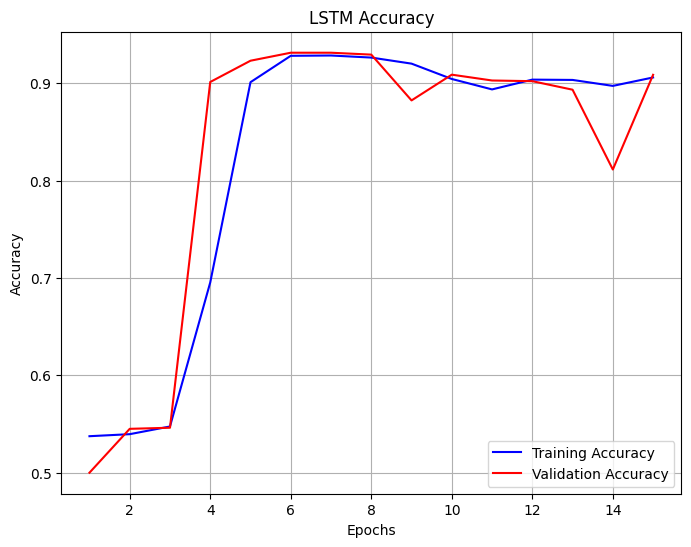

In [13]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(1, len(acc) + 1)


plt.figure(figsize=(8,6))
plt.plot(epochs, acc, 'b-', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r-', label='Validation Accuracy')
plt.title('LSTM Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

In [14]:
from sklearn.metrics import precision_score, recall_score, f1_score

y_pred = model.predict(X_test_pad)
y_pred_classes = (y_pred > 0.5).astype("int32")

precision = precision_score(y_test, y_pred_classes)
recall = recall_score(y_test, y_pred_classes)
f1 = f1_score(y_test, y_pred_classes)

print(f"Precision: {precision*100:.3f}")
print(f"Recall:    {recall*100:.3f}")
print(f"F1 Score:  {f1*100:.3f}")


281/281 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step
Precision: 87.864
Recall:    96.975
F1 Score:  92.195


281/281 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step


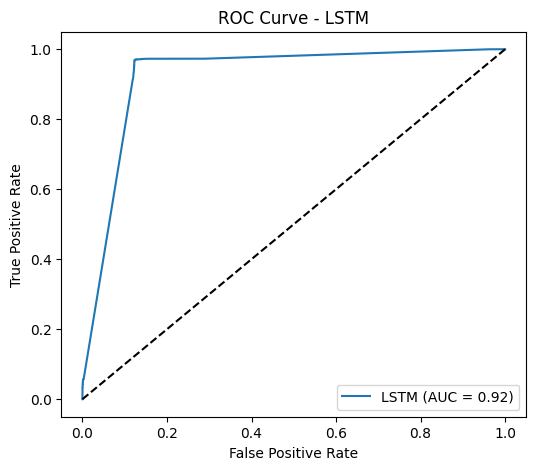

In [34]:
from sklearn.metrics import roc_curve, auc, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
y_prob = model.predict(X_test_pad).ravel()
#y_prob = y_prob[:, 1]           

y_pred = (y_prob >= 0.5).astype(int)

fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f"LSTM (AUC = {roc_auc:.2f})")
plt.plot([0,1],[0,1],'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - LSTM")
plt.legend(loc="lower right")
plt.show()


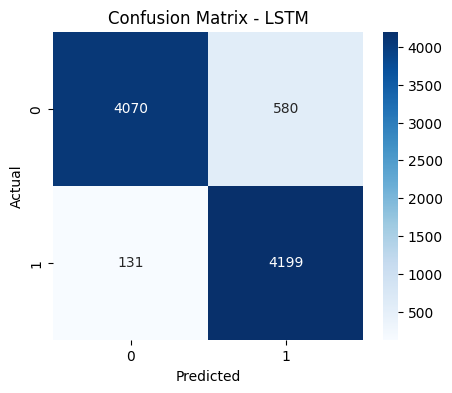

In [35]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix - LSTM")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# RNN

In [21]:
model_rnn = Sequential()

model_rnn.add(Embedding(input_dim=voc_size, output_dim=128, input_length=max_len))
model_rnn.add(SimpleRNN(64, return_sequences=False))
model_rnn.add(Dropout(0.3))
model_rnn.add(Dense(1, activation='sigmoid'))

model_rnn.compile(loss='binary_crossentropy',optimizer=Adam(learning_rate=0.001),metrics=['accuracy'])
model_rnn.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn (SimpleRNN)          │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [22]:
history_rnn = model_rnn.fit(X_train_pad, y_train, epochs=15, verbose=1,
                    validation_split=0.2, batch_size=128, 
                    callbacks=[early_stopping])


Epoch 1/15


I0000 00:00:1756331251.399069     105 service.cc:148] XLA service 0x799ae01ecbb0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1756331251.400827     105 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1756331251.400849     105 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5


  2/225 ━━━━━━━━━━━━━━━━━━━━ 11s 51ms/step - accuracy: 0.5117 - loss: 0.7001

I0000 00:00:1756331253.070350     105 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


225/225 ━━━━━━━━━━━━━━━━━━━━ 16s 51ms/step - accuracy: 0.5223 - loss: 0.6913 - val_accuracy: 0.5238 - val_loss: 0.6845
Epoch 2/15
225/225 ━━━━━━━━━━━━━━━━━━━━ 9s 41ms/step - accuracy: 0.5217 - loss: 0.6931 - val_accuracy: 0.5377 - val_loss: 0.6832
Epoch 3/15
225/225 ━━━━━━━━━━━━━━━━━━━━ 9s 41ms/step - accuracy: 0.5165 - loss: 0.7033 - val_accuracy: 0.5195 - val_loss: 0.6849
Epoch 4/15
225/225 ━━━━━━━━━━━━━━━━━━━━ 9s 41ms/step - accuracy: 0.5332 - loss: 0.6938 - val_accuracy: 0.5401 - val_loss: 0.6831
Epoch 5/15
225/225 ━━━━━━━━━━━━━━━━━━━━ 9s 41ms/step - accuracy: 0.5211 - loss: 0.6919 - val_accuracy: 0.5404 - val_loss: 0.6824
Epoch 6/15
225/225 ━━━━━━━━━━━━━━━━━━━━ 9s 41ms/step - accuracy: 0.5274 - loss: 0.6870 - val_accuracy: 0.5404 - val_loss: 0.6825
Epoch 7/15
225/225 ━━━━━━━━━━━━━━━━━━━━ 9s 41ms/step - accuracy: 0.5287 - loss: 0.6849 - val_accuracy: 0.5399 - val_loss: 0.6783
Epoch 8/15
225/225 ━━━━━━━━━━━━━━━━━━━━ 9s 41ms/step - accuracy: 0.5386 - loss: 0.6838 - val_accuracy: 0.54

In [28]:
acc = model_rnn.evaluate(X_test_pad,y_test)
print("Test accuracy : ",acc)

281/281 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.5524 - loss: 0.6746
Test accuracy :  [0.6755837798118591, 0.5437639355659485]


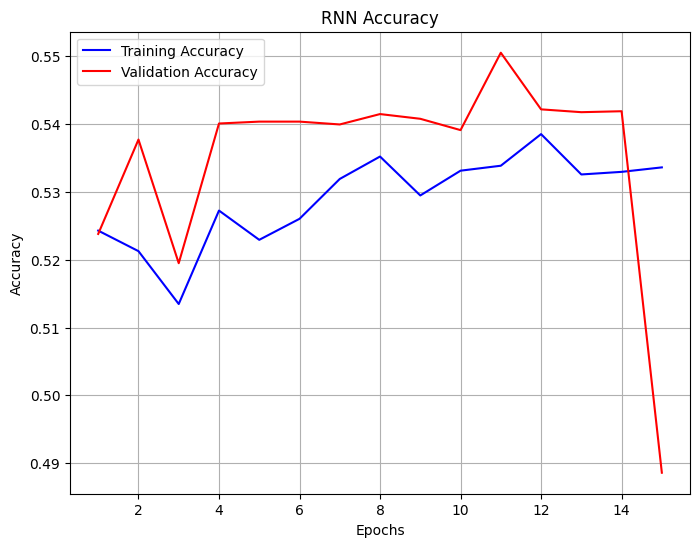

In [29]:
acc = history_rnn.history['accuracy']
val_acc = history_rnn.history['val_accuracy']
epochs = range(1, len(acc) + 1)


plt.figure(figsize=(8,6))
plt.plot(epochs, acc, 'b-', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r-', label='Validation Accuracy')
plt.title('RNN Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

In [38]:
y_pred = model_rnn.predict(X_test_pad)
y_pred_classes = (y_pred > 0.5).astype("int32")

precision = precision_score(y_test, y_pred_classes)
recall = recall_score(y_test, y_pred_classes)
f1 = f1_score(y_test, y_pred_classes)

print(f"Precision: {precision*100:.3f}")
print(f"Recall:    {recall*100:.3f}")
print(f"F1 Score:  {f1*100:.3f}")

281/281 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step
Precision: 77.541
Recall:    7.575
F1 Score:  13.802


281/281 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step


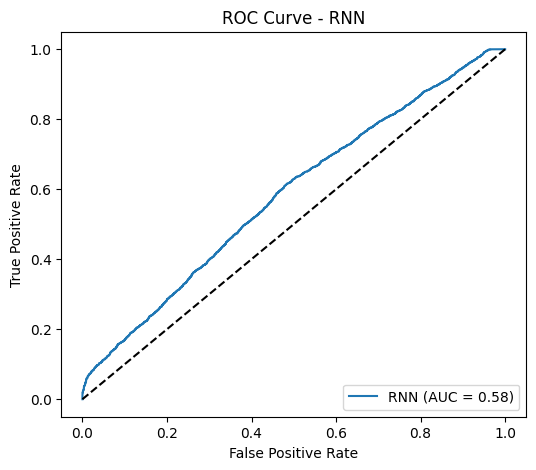

In [39]:
from sklearn.metrics import roc_curve, auc, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
y_prob = model_rnn.predict(X_test_pad).ravel()
#y_prob = y_prob[:, 1]           

y_pred = (y_prob >= 0.5).astype(int)

fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f"RNN (AUC = {roc_auc:.2f})")
plt.plot([0,1],[0,1],'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - RNN")
plt.legend(loc="lower right")
plt.show()


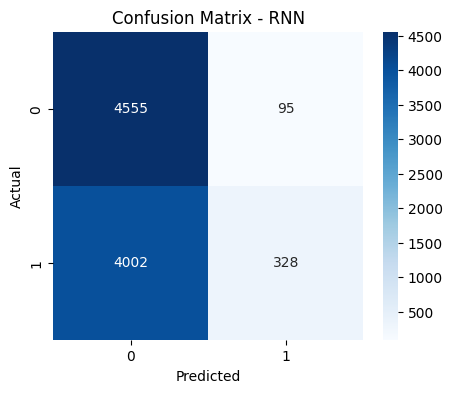

In [40]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix - RNN")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# GRU

In [41]:
model_gru = Sequential()
model_gru.add(Embedding(input_dim=voc_size, output_dim=128, input_length=max_len))
model_gru.add(GRU(64, return_sequences=False))  # GRU layer
model_gru.add(Dropout(0.3))
model_gru.add(Dense(1, activation='sigmoid'))

model_gru.compile(loss='binary_crossentropy',
                  optimizer=Adam(learning_rate=0.001),
                  metrics=['accuracy'])

model_gru.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru (GRU)                       │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [42]:
history_gru = model_gru.fit(
    X_train_pad, y_train,
    epochs=15,
    batch_size=128,
    validation_split=0.2,
    verbose=1,
    callbacks=[early_stopping]
)

Epoch 1/15
225/225 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step - accuracy: 0.5267 - loss: 0.6894 - val_accuracy: 0.5473 - val_loss: 0.6690
Epoch 2/15
225/225 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - accuracy: 0.5344 - loss: 0.6756 - val_accuracy: 0.5539 - val_loss: 0.6594
Epoch 3/15
225/225 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - accuracy: 0.7890 - loss: 0.4027 - val_accuracy: 0.9518 - val_loss: 0.1499
Epoch 4/15
225/225 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - accuracy: 0.9488 - loss: 0.1454 - val_accuracy: 0.9691 - val_loss: 0.1103
Epoch 5/15
225/225 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - accuracy: 0.9687 - loss: 0.1032 - val_accuracy: 0.9542 - val_loss: 0.1494
Epoch 6/15
225/225 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - accuracy: 0.9563 - loss: 0.1366 - val_accuracy: 0.9683 - val_loss: 0.1025
Epoch 7/15
225/225 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - accuracy: 0.9791 - loss: 0.0707 - val_accuracy: 0.9697 - val_loss: 0.0900
Epoch 8/15
225/225 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - accuracy: 0.9862 - loss: 0.0509 - val_accu

In [43]:
acc = model_gru.evaluate(X_test_pad,y_test)
print("Test accuracy : ",acc)

281/281 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.9792 - loss: 0.0746
Test accuracy :  [0.0751725435256958, 0.9788418412208557]


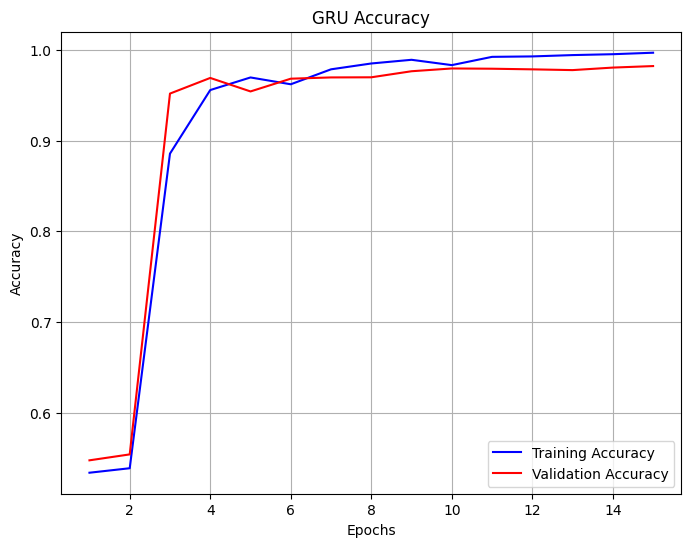

In [44]:
acc = history_gru.history['accuracy']
val_acc = history_gru.history['val_accuracy']
epochs = range(1, len(acc) + 1)


plt.figure(figsize=(8,6))
plt.plot(epochs, acc, 'b-', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r-', label='Validation Accuracy')
plt.title('GRU Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

In [45]:
y_pred = model_gru.predict(X_test_pad)
y_pred_classes = (y_pred > 0.5).astype("int32")

precision = precision_score(y_test, y_pred_classes)
recall = recall_score(y_test, y_pred_classes)
f1 = f1_score(y_test, y_pred_classes)

print(f"Precision: {precision*100:.3f}")
print(f"Recall:    {recall*100:.3f}")
print(f"F1 Score:  {f1*100:.3f}")

281/281 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step
Precision: 97.674
Recall:    97.945
F1 Score:  97.809


281/281 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step


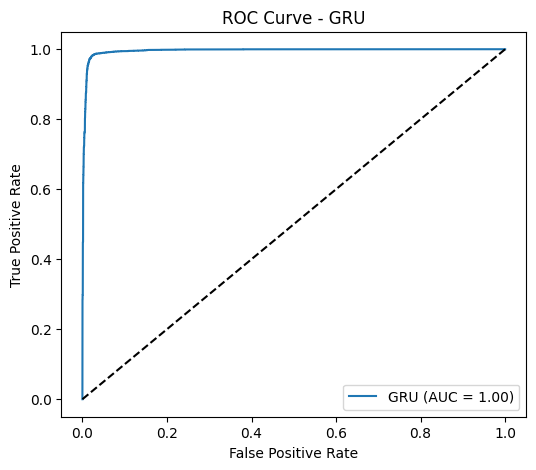

In [ ]:
from sklearn.metrics import roc_curve, auc, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
y_prob = model_gru.predict(X_test_pad).ravel()

y_pred = (y_prob >= 0.5).astype(int)

fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f"GRU (AUC = {roc_auc:.2f})")
plt.plot([0,1],[0,1],'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - GRU")
plt.legend(loc="lower right")
plt.show()

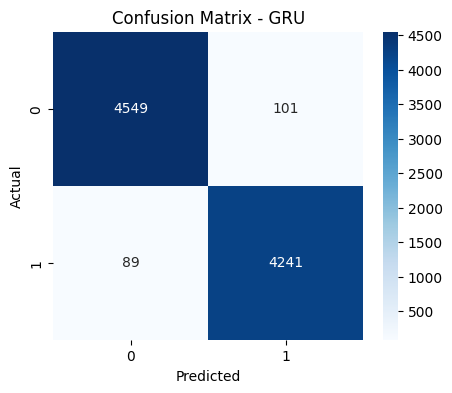

In [50]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix - GRU")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()